# Readme.md
- Upload your photos to data folder
- Run Resize_Image_and_Mask.ipynb
- Draw your bounding boxes
- Resized images should be saved at data/resized and masked images should be saved at data/masked
- Transfer images and masks to dataset folder in freecustom, name folder to target concept of images (i.e, “man_hat_sunglasses”)
- Edit configuration.yaml, refer to existing data samples
- Conda activate ‘/anaconda3/envs/freecustom’ if running in labs servers.
- cd Freecustom
- Run “python free_custom_stable_diffusion.py”
- Output should be saved in results folder with corresponding date and time as folder name

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /data/xxq/FreeCustom


In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/data/xxq/FreeCustom/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
!mkdir -p {HOME}/data

SAMPLE DATA

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

FOLDER_PATH = os.path.join(HOME, "data")
DESTINATION_PATH = os.path.join(HOME, "data","resized_images")
MASKS_PATH = os.path.join(HOME, "data","masks")

In [ ]:
def display_image(image_path):
    img = cv2.imread(image_path)
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


RESIZE RAW IMAGE AND SAVE IN NEW FOLDER

In [ ]:
import cv2
def iterate_images(folder_path):
    # List of common image extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

    folder = Path(folder_path)
    destination_path = os.path.join(folder_path, 'resized_images')
    os.makedirs(destination_path, exist_ok=True)

    # Method 1: Using pathlib
    for image_path in folder.glob('*'):
        if image_path.suffix.lower() in image_extensions:
            print(f"Found image: {image_path}")

            # Read image with error checking
            image = cv2.imread(str(image_path))
            if image is None:
                print(f"Error: Could not read image at {image_path}")
                continue

            # Resize image
            try:
                resized_image = cv2.resize(image, (512, 512))
                new_path = os.path.join(destination_path, image_path.name)
                cv2.imwrite(new_path, resized_image)
                print(f"Saved: {new_path}")
                display_image(new_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

Found image: /content/data/W2xQZxs7T2gUE2fMbUv4s6.jpg
Saved: /content/data/resized_images/W2xQZxs7T2gUE2fMbUv4s6.jpg


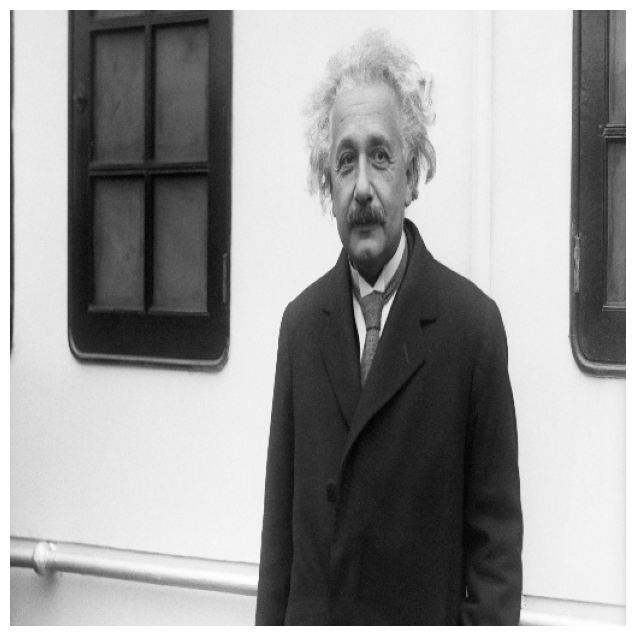

Found image: /content/data/images.jpeg
Saved: /content/data/resized_images/images.jpeg


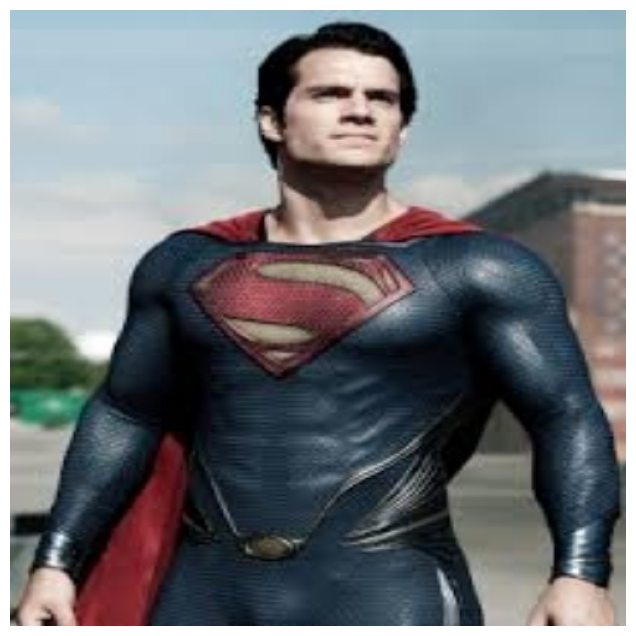

In [ ]:
iterate_images(FOLDER_PATH)

In [ ]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json

path = DESTINATION_PATH
files = sorted(os.listdir(path))
annotations = {}
annotations_path = 'annotations.json'


widget = BBoxWidget()
w_progress = widgets.IntProgress(value=0, max=len(files), description='Progress')
# the bbox widget
w_bbox = BBoxWidget(
    image = os.path.join(path, files[0])
)

# combine widgets into a container
w_container = widgets.VBox([
    w_progress,
    w_bbox,
])

In [ ]:
@w_bbox.on_skip
def skip():
    if(w_progress.value >= len(files)-1):
      return 0
    print(w_progress.value)
    w_progress.value += 1
    image_file = files[w_progress.value]
    w_bbox.image = os.path.join(path, image_file)
    w_bbox.bboxes = []

@w_bbox.on_submit
def submit():
    image_file = files[w_progress.value]
    # save annotations for current image
    annotations[image_file] = w_bbox.bboxes
    with open(annotations_path, 'w') as f:
        json.dump(annotations, f, indent=4)
    # move on to the next file

    if(w_progress.value >= len(files)-1):
      clear_output
    else:
      skip()

In [ ]:
w_container

0


NameError: name 'clear_output' is not defined

In [ ]:
coords = {}

In [ ]:
def predict_masks(image_name,coords):
  image_bgr = cv2.imread(os.path.join(DESTINATION_PATH,image_name))
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  mask_predictor.set_image(image_rgb)

  masks, scores, logits = mask_predictor.predict(
      box=coords,
      multimask_output=True
  )
  return masks

Image: images.jpeg
Coordinates: [ 14 150 508 506]
(3, 512, 512)


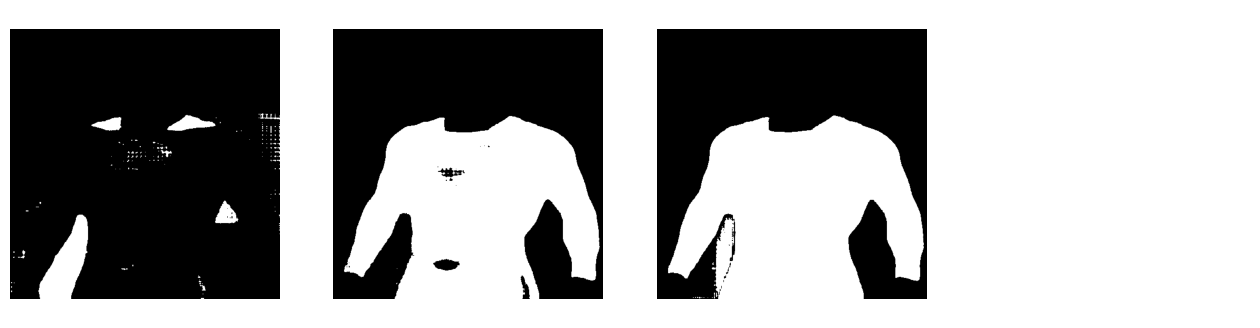

In [ ]:
import numpy as np
import json
import supervision as sv
# Load the JSON file
with open('annotations.json', 'r') as f:
    annotations = json.load(f)

os.makedirs(MASKS_PATH, exist_ok=True)

# Function to process each image's bounding boxes
def process_boxes(image_name):
    default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

    # Get boxes for this image, or use default if none exist
    boxes = annotations.get(image_name, [])
    if not boxes:
        box = default_box
    else:
        box = boxes[0]  # Get first box

    # Convert to numpy array format
    box_coords = np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])

    return box_coords

# Example usage:
for image_name in annotations.keys():
    coords = process_boxes(image_name)
    print(f"Image: {image_name}")
    print(f"Coordinates: {coords}")
    masks = predict_masks(image_name,coords)
    print(masks.shape)
    sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
    )

    for i in range(masks.shape[0]):

        mask_channel = masks[i].astype(np.uint8) * 255

        mask_path = os.path.join(MASKS_PATH, f'mask_{i}_{image_name}')
        cv2.imwrite(mask_path, mask_channel)
